The following notebook is obtained from https://www.kaggle.com/dongxu027/airline-delays-eda-deep-dive-lessons-learned/comments, with the work being done by the user dongxu027 on Kaggle, and slight modifications made for our purposes.

In [ ]:
!python -m pip install --upgrade pip

In [ ]:
!pip install plotly seaborn

# Contents

I published a post explaining a bit of data definitions and relationships in the following link:
https://www.kaggle.com/usdot/flight-delays/discussion/29308
For anyone interested to check out.

Thanks for some of the inspirations by the awesome kernel from FabienDaniel:    
https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial 

# Library Import & Initial Data Explore

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline
import datetime, warnings, scipy 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits import Basemap
#from scipy.optimize.basemap import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

In [41]:
#airlines = pd.read_csv('../input/airlines.csv')
#airports= pd.read_csv('../input/airports.csv')
#flights = pd.read_csv('../input/flights.csv', low_memory=False)
#print (airlines.shape)
#print (airports.shape)
#print (flights.shape)

flights = pd.read_csv('flights.csv') 
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')

Let's explore a bit further on the last portion of the missing data - cancellation reason & various delays

In [31]:
print (flights.shape[0]*flights.CANCELLED.mean())
print (flights.shape[0] - flights.CANCELLATION_REASON.isnull().sum())

89884.0
89884


The two numbers match up, which infers that only the cancelled flights have a cancellation reason. Intuitive!

In [34]:
print (flights['ARRIVAL_DELAY'][flights['ARRIVAL_DELAY'] >= 15].count())
print (flights.shape[0] - flights.AIR_SYSTEM_DELAY.isnull().sum())

1063439
1063439


The two numbers match up, which infers that only the flights with arrival delay >= 15 minutes having a detailed delay breakdown (e.g. air system, airline, weather).

Join the airline data to get started for the analysis

In [36]:
flights_v1 = pd.merge(flights, airlines, left_on='AIRLINE', right_on='IATA_CODE', how='left')
flights_v1.drop('IATA_CODE', axis=1, inplace=True)
flights_v1.rename(columns={'AIRLINE_x': 'AIRLINE_CODE','AIRLINE_y': 'AIRLINE'}, inplace=True)

In [37]:
flights_v1.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.


# Delay Plots

##### For each airline carrier's flights, obtain the mean departure delay by origin airport.

In [42]:
airport_mean_delays = pd.DataFrame(pd.Series(flights['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)
abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()
identify_airport = airports.set_index('IATA_CODE')['CITY'].to_dict()

# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#___________________________________________________________

for carrier in abbr_companies.keys():
    fg1 = flights[flights['AIRLINE'] == carrier]
    test = fg1['DEPARTURE_DELAY'].groupby(flights['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

##### Show the mean departure delay as a heatmap, (left plot is 50 of the airports, right plot is the other 50 airports)

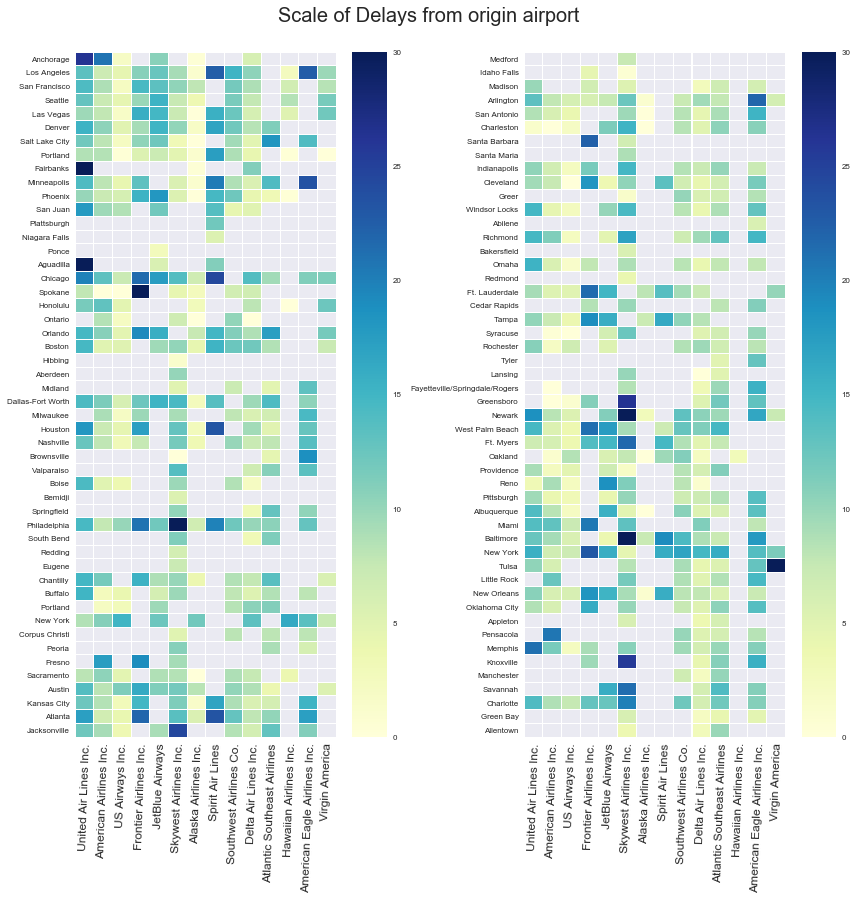

In [52]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(12,12))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 30)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 88) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Scale of Delays from origin airport", ha='center', fontsize = 20)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.05, cmap="YlGnBu", mask=mask, vmin = 0, vmax = 30)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 88) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

Looks like the airlines with most number of flights in 2015 are Southwest (1.2M flights - ranked No.1), Delta, American and Skywest, which also have relatively low cancellation rate. American Eagle has the highest cancellation rate - around 5%. 

Also, the divertion rate seems positively correlated with the flight volume. Overall the divertion rate is less than 1%.

##### Mean departure delay and mean arrival delay by airline

Text(0.5,1,'Mean delay at arrival')

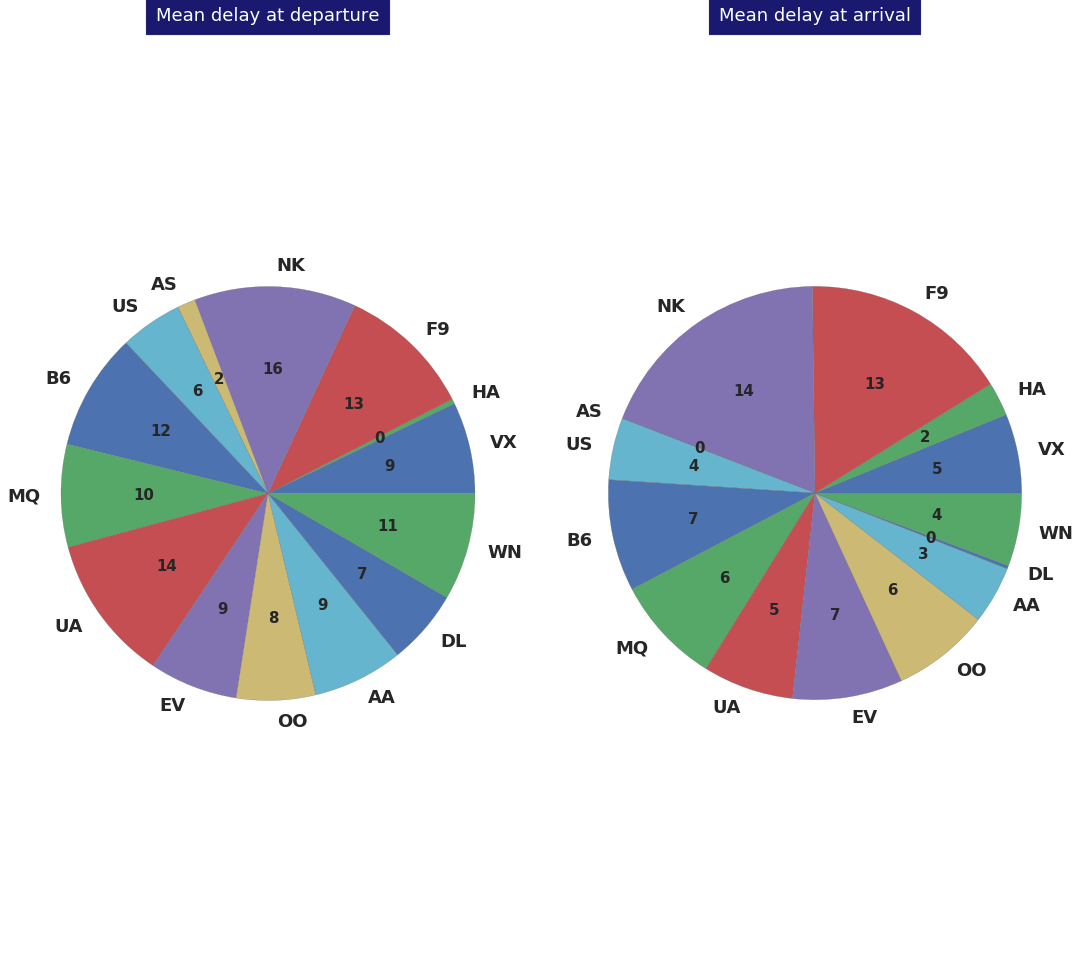

In [53]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# extract a subset of columns and redefine the airlines labeling 
fg2 = flights.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
fg2['AIRLINE'] = fg2['AIRLINE'].replace(abbr_companies)
fig = plt.figure(1, figsize=(16,16))
gs=GridSpec(1,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 

global_stats_d=flights['DEPARTURE_DELAY'].groupby(flights['AIRLINE']).apply(get_stats).unstack()
global_stats_d=global_stats_d.sort_values('count')

global_stats_a=flights['ARRIVAL_DELAY'].groupby(flights['AIRLINE']).apply(get_stats).unstack()
global_stats_a=global_stats_a.sort_values('count')

#----------------------------------------
# Pie chart nº1: mean delay at departure
#----------------------------------------
labels = [s for s in  global_stats_d.index]
sizes  = global_stats_d['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode, labels = labels, shadow=False, startangle=0, 
                                    autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(18)
ax1.axis('equal')
ax1.set_title('Mean delay at departure', bbox={'facecolor':'midnightblue', 'pad':10},
              color='w', fontsize=18)

#----------------------------------------
# Pie chart nº2: mean delay at arrival
#----------------------------------------
labels = [s for s in  global_stats_a.index]
sizes  = global_stats_a['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels, shadow=False, startangle=0,
                                     autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(18)
ax2.axis('equal')
ax2.set_title('Mean delay at arrival', bbox={'facecolor':'midnightblue', 'pad':10},
              color='w', fontsize=18)

In [54]:
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


# Flight Volume, Cancellation & Divertion Rate

##### Does not work since we did not import Basemap since that package is no longer supported. Refer to https://www.kaggle.com/dongxu027/airline-delays-eda-deep-dive-lessons-learned/notebook

In [72]:
count_flights = flights['ORIGIN_AIRPORT'].value_counts()
#___________________________
plt.figure(figsize=(16,16))
#________________________________________
# define properties of markers and labels
colors = ['lightblue', 'yellow', 'orange', 'purple', 'red' ]
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Cartopy(resolution='h',llcrnrlon=-124.7844079, urcrnrlon=-66.9513812,
              llcrnrlat=24.7433195, urcrnrlat=49.3457868, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='1')
#_____________________
# put airports on map
for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+3, 
             markeredgewidth = 1.5, color = colors[ind], label = labels[ind])

#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 4, prop= {'size':14},
           title='Number of flights in 2015', frameon = True, framealpha = 1)
plt.show()

NameError: name 'Cartopy' is not defined

<Figure size 1152x1152 with 0 Axes>

In [67]:
airline_rank_v01 = pd.DataFrame({'flight_volume' : flights_v1.groupby(['AIRLINE'])['FLIGHT_NUMBER'].count()}).reset_index()
airline_rank_v01.sort_values("flight_volume", ascending=True, inplace=True)
flight_volume_total = airline_rank_v01['flight_volume'].sum()
airline_rank_v01['flight_pcnt'] = airline_rank_v01['flight_volume']/flight_volume_total

In [68]:
airline_rank_v02 = pd.DataFrame({'cancellation_rate' : flights_v1.groupby(['AIRLINE'])['CANCELLED'].mean()}).reset_index()
airline_rank_v02.sort_values("cancellation_rate", ascending=False, inplace=True)
airline_rank_v03 = pd.DataFrame({'divertion_rate' : flights_v1.groupby(['AIRLINE'])['DIVERTED'].mean()}).reset_index()
airline_rank_v03.sort_values("divertion_rate", ascending=False, inplace=True)
airline_rank_v1 = pd.merge(airline_rank_v01, airline_rank_v02, left_on='AIRLINE', right_on='AIRLINE', how='left')
airline_rank_v1 = pd.merge(airline_rank_v1, airline_rank_v03, left_on='AIRLINE', right_on='AIRLINE', how='left')

In [69]:
airline_rank_v1

,AIRLINE,flight_volume,flight_pcnt,cancellation_rate,divertion_rate
0,Virgin America,61903,0.010638,0.008626,0.001955
1,Hawaiian Airlines Inc.,76272,0.013107,0.002242,0.000787
2,Frontier Airlines Inc.,90836,0.015610,0.006473,0.001739
3,Spirit Air Lines,117379,0.020171,0.017073,0.001551
4,Alaska Airlines Inc.,172521,0.029647,0.003878,0.002394
5,US Airways Inc.,198715,0.034149,0.020466,0.002139
6,JetBlue Airways,267048,0.045892,0.016012,0.002734
7,American Eagle Airlines Inc.,294632,0.050632,0.050996,0.002770
8,United Air Lines Inc.,515723,0.088626,0.012745,0.002691
9,Atlantic Southeast Airlines,571977,0.098293,0.026629,0.003486


# Taxi-in & Taxi-out Time 

In [81]:
airline_rank_v04 = pd.DataFrame({'taxi_out_time' : flights_v1.groupby(['AIRLINE'])['TAXI_OUT'].mean()}).reset_index()
airline_rank_v05 = pd.DataFrame({'taxi_in_time' : flights_v1.groupby(['AIRLINE'])['TAXI_IN'].mean()}).reset_index()

[Text(0.5,0,'taxi_time (taxi_in: blue, taxi_out: green)')]

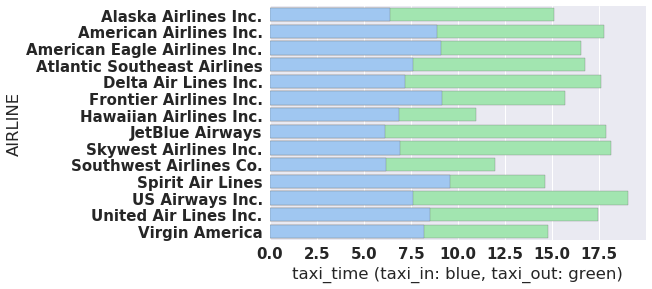

In [84]:
ax = plt.subplots()
sns.set_color_codes("pastel")
sns.set_context("notebook", font_scale=1.5)
ax = sns.barplot(x="taxi_out_time", y="AIRLINE", data=airline_rank_v04, color="g")
ax = sns.barplot(x="taxi_in_time", y="AIRLINE", data=airline_rank_v05, color="b")
ax.set(xlabel="taxi_time (taxi_in: blue, taxi_out: green)")

Interestingly, we can see that overall taxi in time is less than taxi out time for all the airlines. All airlines have an average taxi_in time less than 10 minutes, while all taxi out time are greater than 10 minutes. Also, it seems Southwest has the shortest taxi-in and taxi-out time (at least among the shortest).

# Airline Flight Speed (miles/hour)

In [ ]:
flights_v1['fly_speed'] = 60*flights_v1['DISTANCE']/flights_v1['AIR_TIME']
sns.set_context("notebook", font_scale=20)
sns.set(style="ticks", palette="muted", color_codes=True)
ax = sns.violinplot(x="fly_speed", y="AIRLINE", data=flights_v1, figsize = (24, 16));
sns.despine(trim=True)

Based on the violinplot, we can see that in average, the majority of flying speed accross airlines are close to 400~450 miles per hour; with the Hawaiian Airlines Inc. is the slowest airline and also large variation (by simply looking at the data shape distribution). 

It is intersting to see that in some rare cases, an aircraft can go as high as 800 miles per hour in average during a flight trip (recall how I calculate this value). United Airlines seems the fastest, while Hawaiian Airlines seems at the bottom.


# Arrival & Departure Delays

In [87]:
airline_rank_v07 = pd.DataFrame({'avg_arrival_delay' : flights_v1.groupby(['AIRLINE'])['ARRIVAL_DELAY'].mean()}).reset_index()
airline_rank_v08 = pd.DataFrame({'avg_departure_delay' : flights_v1.groupby(['AIRLINE'])['DEPARTURE_DELAY'].mean()}).reset_index()

In [88]:
airline_rank_v1 = pd.merge(airline_rank_v1, airline_rank_v07, left_on='AIRLINE', right_on='AIRLINE', how='left')
airline_rank_v1 = pd.merge(airline_rank_v1, airline_rank_v08, left_on='AIRLINE', right_on='AIRLINE', how='left')

[Text(0.5,0,'delay_time (arrival: red, departure: blue)')]

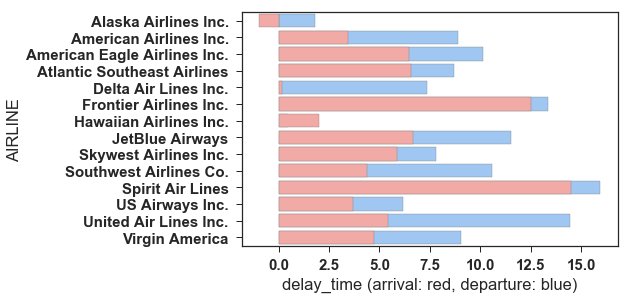

In [89]:
ax = sns.set_color_codes("pastel")
sns.set_context("notebook", font_scale=1.5)
ax = sns.barplot(x="avg_departure_delay", y="AIRLINE", data=airline_rank_v08,
            label="accuracy", color="b")
ax = sns.barplot(x="avg_arrival_delay", y="AIRLINE", data=airline_rank_v07,
            label="accuracy", color="r")
ax.set(xlabel="delay_time (arrival: red, departure: blue)")

Based on this analysis, looks like all the lines have longer departure delays than arrival delays, except for Hawwaiian Airlines. My intuition is that the flights can adjust speed to catch up time while departure delay sometimes are out of control.

Spirit Airlines and Frontier Airlines are among the longest arrival and departure delay airlines. It is worth noting that Alaska Airlines is the only airline among all to arrive the destination earlier than scheduled in average.